**Data Visualization**

## Imports

In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import set_config
set_config(transform_output='pandas')

import joblib

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

In [2]:
import os
os.makedirs('Data/',exist_ok=True) 
os.listdir("Data/")

['sales_predictions_2023.csv']

In [3]:
#FUNCTION

def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

## Loading Data 


initial inspection and cleaning

In [4]:
df = pd.read_csv('Data/sales_predictions_2023.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
#copy of data
ml_df = df.copy()

In [6]:
ml_df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [7]:
#Columns with high cardinality will be dropped from df
high_card =['Item_Identifier','Outlet_Identifier']
ml_df = df.drop(columns=high_card, axis=1)

In [8]:
obj_col = ml_df.select_dtypes("object").columns
obj_col

Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')

In [9]:
num_col = ml_df.select_dtypes("number").columns
num_col

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

In [10]:
# Standardize the values in the Central column
ml_df['Item_Fat_Content'] = ml_df['Item_Fat_Content'].replace({'LF':"Low Fat", "reg":"Regular", "low fat":"Low Fat"})
ml_df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [11]:
for col in obj_col:
  print(f"Value Counts for {col}")
  print(ml_df[col].value_counts())
  print('\n')

Value Counts for Item_Fat_Content
Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64


Value Counts for Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Value Counts for Outlet_Size
Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64


Value Counts for Outlet_Location_Type
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64


Value Counts for Outlet_Type
Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Typ

In [12]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                7060 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Establishment_Year  8523 non-null   int64  
 6   Outlet_Size                6113 non-null   object 
 7   Outlet_Location_Type       8523 non-null   object 
 8   Outlet_Type                8523 non-null   object 
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 666.0+ KB


## ML

Defining X & Y, preprocessing data

In [13]:
target = 'Item_Outlet_Sales'
X = ml_df.drop(columns=[target])
y = ml_df[target]

# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
8269,7.220,Regular,0.064142,Baking Goods,61.2510,1998,NaN,Tier 3,Grocery Store
7604,6.135,Low Fat,0.079294,Soft Drinks,111.2860,2009,Medium,Tier 3,Supermarket Type2
2762,12.150,Low Fat,0.028593,Household,151.0708,2004,Small,Tier 2,Supermarket Type1
6464,5.945,Low Fat,0.093009,Household,127.8652,2004,Small,Tier 2,Supermarket Type1
4707,18.200,Regular,0.066285,Fruits and Vegetables,247.2092,2004,Small,Tier 2,Supermarket Type1


In [14]:
X_train.shape

(6392, 9)

In [15]:
X_test.shape

(2131, 9)

In [16]:
X_train.dtypes

Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
dtype: object

### Numeric

In [17]:
num_cols = X_train.select_dtypes('number').columns
print("Numeric Columns:", num_cols)


mean_imputer = SimpleImputer(strategy='mean')


num_pipeline = make_pipeline(mean_imputer)
num_pipeline

numeric_tuple = ('numeric',num_pipeline, num_cols)
numeric_tuple

Numeric Columns: Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')


('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer())]),
 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
        'Outlet_Establishment_Year'],
       dtype='object'))

### Ordinal

In [18]:
ord_cols = ['Outlet_Size', 'Outlet_Location_Type']

Outlet_Size_list = ['Small', 'Medium', 'High']
Outlet_Location_list = ['Tier 1', 'Tier 2', 'Tier 3']

ord = OrdinalEncoder(categories=[Outlet_Size_list,Outlet_Location_list])
freq_imputer = SimpleImputer(strategy='most_frequent')

ord_pipeline = make_pipeline(freq_imputer, ord)

ord_tuple = ('ordinal',ord_pipeline, ord_cols)
ord_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['Small', 'Medium', 'High'],
                                            ['Tier 1', 'Tier 2', 'Tier 3']]))])

### Nominal

In [19]:
nominal_cols = X_train.select_dtypes('object').drop(columns=ord_cols).columns

missing_imputer = SimpleImputer(strategy='constant', fill_value='missing')
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

nom_pipeline = make_pipeline(missing_imputer , ohe)

ohe_tuple = ('categorical',nom_pipeline, nominal_cols)
nom_pipeline

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [20]:
preprocessor = ColumnTransformer([numeric_tuple,
                                       ord_tuple,
                                       ohe_tuple],
                                       remainder='drop', verbose_feature_names_out=False)

In [21]:
preprocessor.fit(X_train)
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                         columns=preprocessor.get_feature_names_out(),
                          index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                        columns=preprocessor.get_feature_names_out(),
                        index=X_test.index)
display(X_train_df)

/Users/evelynmartinez/anaconda3/envs/dojo-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,...,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8269,7.220000,0.064142,61.2510,1998.0,1.0,2.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7604,6.135000,0.079294,111.2860,2009.0,1.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2762,12.150000,0.028593,151.0708,2004.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6464,5.945000,0.093009,127.8652,2004.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4707,18.200000,0.066285,247.2092,2004.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3482,12.822634,0.012216,162.7894,1985.0,1.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8360,11.500000,0.014884,174.5080,1999.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5929,5.110000,0.034945,161.1210,2002.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4220,6.550000,0.034800,157.5288,2007.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Regression Model

In [22]:
#Linear Regression Model
lin_reg = LinearRegression()

#Model pipeline
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train,
                   X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.56,827.45,"1,116.54"
Test,0.56,860.34,"1,165.20"


### Coefficients

In [23]:
#FUNCTION

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

In [24]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False):
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
        
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
        
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [25]:
pd.set_option('display.float_format',lambda x: f"{x:,.4f}")
pd.set_option('display.max_rows', None)

In [26]:
coeffs = get_coefficients(lin_reg)
coeffs.sort_values()

Outlet_Type_Grocery Store         -1,712.5447
intercept                         -1,480.9384
Item_Visibility                     -266.4290
Item_Type_Soft Drinks               -116.8081
Outlet_Type_Supermarket Type2       -112.2307
Item_Type_Household                  -69.9817
Item_Type_Dairy                      -47.7869
Item_Type_Health and Hygiene         -39.7153
Outlet_Size                          -27.0351
Item_Fat_Content_Low Fat             -15.3595
Item_Type_Meat                       -12.3296
Item_Type_Snack Foods                 -8.0487
Item_Type_Breads                      -6.7073
Item_Type_Frozen Foods                -2.7519
Outlet_Establishment_Year              0.6914
Item_Weight                            1.3132
Item_Type_Baking Goods                 8.8573
Item_Fat_Content_Regular              15.3595
Item_Type_Fruits and Vegetables       15.5665
Item_MRP                              15.5989
Item_Type_Others                      16.2572
Outlet_Location_Type              

In [27]:
lin_reg_drop = LinearRegression(fit_intercept=False)
lin_reg_drop.fit(X_train_df,y_train)
evaluate_regression(lin_reg_drop, X_train_df, y_train, 
                    X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.56,827.45,"1,116.54"
Test,0.56,860.34,"1,165.20"


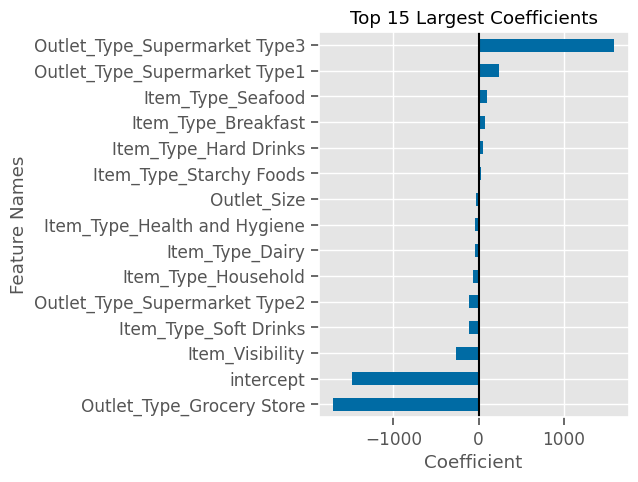

In [28]:
ax= plot_coeffs(coeffs,top_n=15, intercept=True)


- **The top three most important coefficients are:**

- Outlet_Type_Supermarket_Type3: The model shows that Supermarket Type 3 significantly impacts sales compared to other store types. It suggests around 1,590 more units sold in this kind of supermarket compared to the rest.

- Outlet_Type_Supermarket_Type1: Similarly, Supermarket Type 1 also has a positive effect on sales, with around 234 more units sold compared to other types of supermarkets in the dataset.

- Item_Type_Seafood: The model indicates that 'Seafood' items sell about 95
more units compared to other types of food items.


## Random Forest 

In [29]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_df,y_train)
evaluate_regression(rf_reg, X_train_df, y_train, X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.94,294.93,427.54
Test,0.56,819.11,"1,168.62"


In [30]:
import_coeff = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
import_coeff.sort_values(ascending=False)

Item_MRP                          0.4489
Outlet_Type_Grocery Store         0.1968
Item_Visibility                   0.1012
Outlet_Type_Supermarket Type3     0.0538
Item_Weight                       0.0534
Outlet_Establishment_Year         0.0424
Outlet_Size                       0.0103
Outlet_Location_Type              0.0095
Item_Type_Fruits and Vegetables   0.0083
Item_Type_Snack Foods             0.0081
Item_Type_Household               0.0063
Item_Type_Frozen Foods            0.0058
Item_Type_Dairy                   0.0056
Item_Fat_Content_Low Fat          0.0049
Item_Fat_Content_Regular          0.0049
Item_Type_Baking Goods            0.0045
Item_Type_Health and Hygiene      0.0044
Item_Type_Canned                  0.0043
Item_Type_Soft Drinks             0.0042
Item_Type_Meat                    0.0037
Item_Type_Breads                  0.0030
Item_Type_Hard Drinks             0.0029
Item_Type_Starchy Foods           0.0029
Outlet_Type_Supermarket Type1     0.0026
Item_Type_Breakf

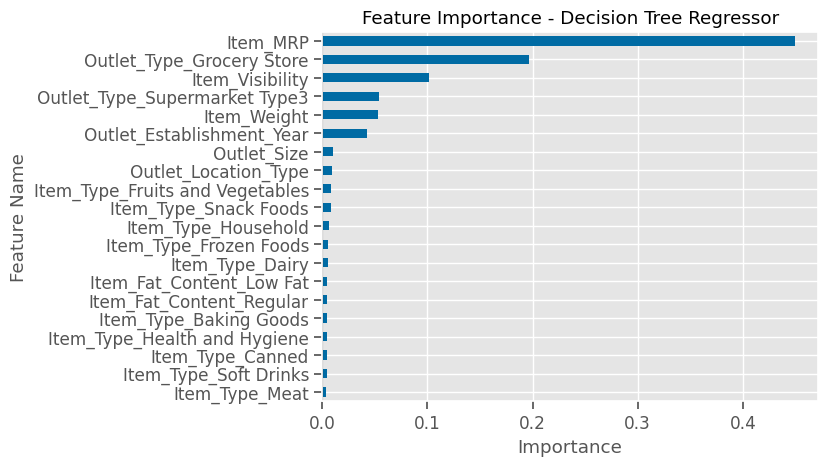

In [31]:
ax = import_coeff.sort_values().tail(20).plot(kind='barh')#,figsize=(6,4))
ax.axvline(0, color='k')
ax.set(title='Feature Importance - Decision Tree Regressor',ylabel="Feature Name",
      xlabel='Importance');

- The top 5 most important features are Item MRP, Grocery Outlet Type, Item Visibility, Item Weight, and 
Supermarket Outlet Type.

## Serialize Best Models with Joblib

In [32]:
import joblib, os

# creating a dictionary of all of the variables to save for later
export = {'X_train':X_train,
         'y_train':y_train,
         'X_test':X_test,
         'y_test':y_test,
          'preprocessor':preprocessor,
         'LinearRegression': lin_reg,
          'RandomForestRegressor':rf_reg}

In [33]:
import os
os.makedirs('Models/', exist_ok=True)
print(os.listdir("Models/"))

folder = 'Models/'
os.makedirs(folder, exist_ok=True)


['Best-Models.joblib']


In [34]:
fname = folder+'Best-Models.joblib'
joblib.dump(export, fname)

['Models/Best-Models.joblib']